In [2]:

import tensorflow as tf
from tensorflow import keras
from keras import layers,models,optimizers 
from keras import backend as K
from collections import namedtuple,deque
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizer_v2.adam import Adam
from collections import deque

In [3]:
import numpy as np
import pandas as pd
from pandas import set_option
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from numpy.random import choice
import random

In [4]:
url = 'https://raw.githubusercontent.com/tatsath/fin-ml/master/Chapter%209%20-%20Reinforcement%20Learning/Case%20Study%201%20-%20Reinforcement%20Learning%20based%20Trading%20Strategy/data/SP500.csv'
ds = pd.read_csv(url,index_col=0)
ds.shape

(2516, 6)

In [5]:
set_option('display.width', 100)
ds.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [6]:
print('Null Values =',ds.isnull().values.any())

Null Values = False


In [7]:
X = list(ds['Close'])
X = [float(x) for x in X]
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size],X[train_size:len(X)]

In [8]:
class Agent:
  def __init__(self, state_size, is_eval=False, model_name=""):
    self.state_size = state_size # normalized previous days 
    self.action_size = 3 # hold, buy, sell
    self.memory = deque(maxlen=1000)
    self.inventory = []
    self.model_name = model_name
    self.is_eval = is_eval
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = load_model("models/" + model_name) if is_eval else self._model()

  def _model(self):
    model = Sequential()
    model.add(Dense(units=64, input_dim=self.state_size, activation="relu")) 
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=8, activation="relu")) 
    model.add(Dense(self.action_size, activation="linear")) 
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    return model

  def act(self, state):
    if not self.is_eval and random.random() <= self.epsilon:
      return random.randrange(self.action_size) 
    options = self.model.predict(state)
    return np.argmax(options[0])

  def expReplay(self, batch_size):
    mini_batch = []
    l = len(self.memory)
    #1: Prepare replay memory
    for i in range(l - batch_size + 1, l):
        mini_batch.append(self.memory[i])


    #2: Loop across the replay memory batch.
    for state, action, reward, next_state, done in mini_batch:
        target = reward # Q at time t 
        #3: update the target for Q table. table equation
        if not done:
            target = reward + self.gamma * \
                np.amax(self.model.predict(next_state)[0])
    #set_trace()
    # 4: Q-value of the state currently from the table
        target_f = self.model.predict(state)
    # 5: Update the output Q table for the given action in the table
        target_f[0][action] = target
    # 6. train and fit the model.
        self.model.fit(state, target_f, epochs=1, verbose=0)
    #7. Implement epsilon greedy algorithm
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay


In [9]:
##Helper Functions
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def formatPrice(n):
    return (
        ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))
    )

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n-1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(data_input, color='r', lw=2)
    plt.plot(
        data_input, '^', markersize=10, color='m', 
        label = 'Buying Signal', markevery=states_buy
        )
    plt.plot(
        data_input, 'v', markersize=10, color='k',
        label='Selling Signal', markevery=states_sell
    )
    plt.title('Total Gains: %f' % profit)
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Episode 0/3
---------
Total Profit: $1329.87
---------


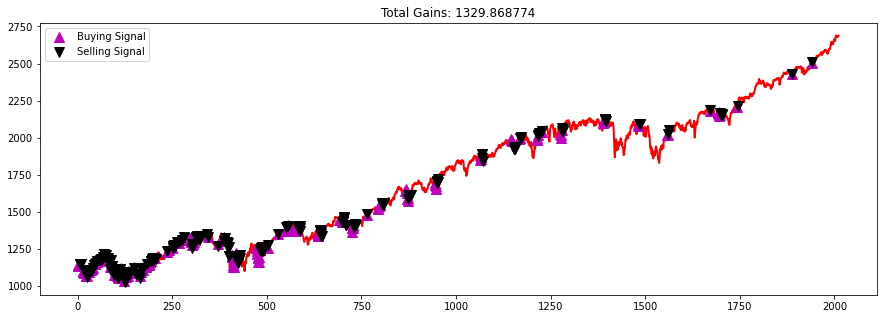

Episode 1/3
---------
Total Profit: $708.95
---------


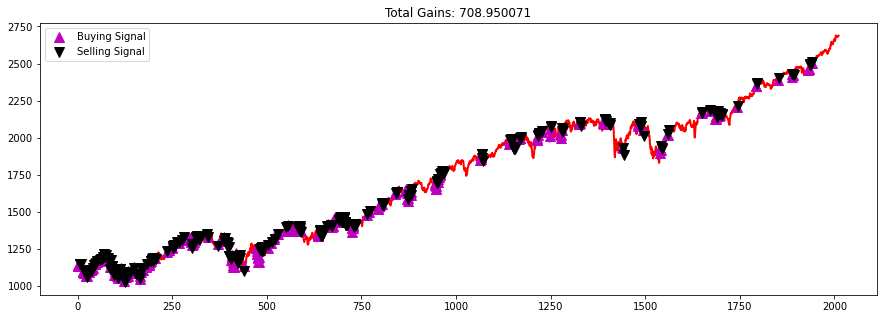

Episode 2/3
---------
Total Profit: -$625.41
---------


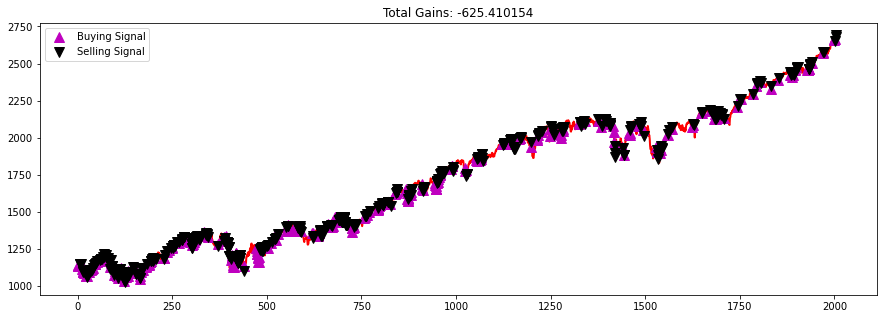

Episode 3/3
---------
Total Profit: $1839.33
---------


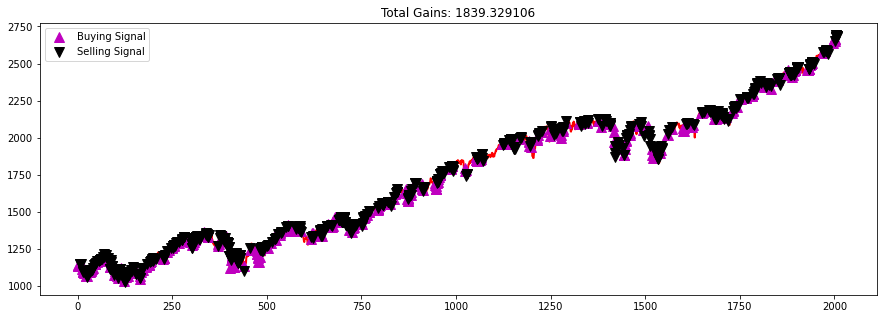

INFO:tensorflow:Assets written to: models/models_ep3/assets


In [10]:
window_size = 1
agent = Agent(window_size)
data = X_train
l = len(data) -1
batch_size = 10
states_sell = []
states_buy = []
episode_count = 3

for e in range(episode_count + 1):
    print('Episode ' + str(e) + '/' + str(episode_count))
    # 1-get state
    state = getState(data, 0, window_size + 1)

    total_profit = 0
    agent.inventory = []

    for t in range(l):
        # 2-apply best action
        action = agent.act(state)
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            # get reward

            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)

        
        done = True if t == l - 1 else False
        # get next state
        next_state = getState(data, t + 1, window_size + 1)
        # add to memory
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print('---------')
            print('Total Profit: ' + formatPrice(total_profit))
            print('---------')

            plot_behavior(
                data,states_buy,states_sell,total_profit
            )
        # 6: Run replay buffer function
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)

    if e % 3 == 0 and e != 0:
        agent.model.save('models/models_ep' + str(e))            


In [11]:
print(agent.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 2,499
Trainable params: 2,499
Non-trainable params: 0
_________________________________________________________________
None


---------
Total Profit: -$155.27
---------


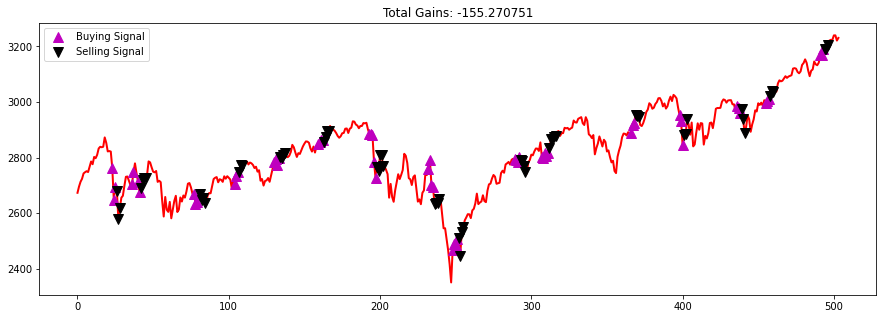

In [15]:
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
model_name = 'models_ep3'
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size+1)
total_profit = 0
agent.inventory = []

for t in range(l_test):
    action = agent.act(state)

    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
    
    if t == l_test - 1:
        done = True
    else:
        done = False
    
    # get next state
    next_state = getState(data, t + 1, window_size + 1)
    # add to memory
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    # 6: Run replay buffer function
    if len(agent.memory) > batch_size:
        agent.expReplay(batch_size)
        
    if done:
        print('---------')
        print('Total Profit: ' + formatPrice(total_profit))
        print('---------')
plot_behavior(test_data, states_buy_test, states_sell_test, total_profit)